In [1]:
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
T = 100
K = 2
mu = [0.2, 0.8]

In [3]:
# Specify the random responding model as a function
def simulate_RandomModel(b, T, mu):
    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)
    
    for t in range(T):

        # compute choice probabilities
        p = [b, 1-b]

        # make choice according to choice probababilities
        c[t] = np.random.choice(range(len(mu)), p=p)

        # generate reward based on choice
        r[t] = np.random.rand() < mu[c[t]]
    
    return c, r

In [4]:
# simulate the random responding model
c1, r1 = simulate_RandomModel(b=.5, T=T, mu=mu)

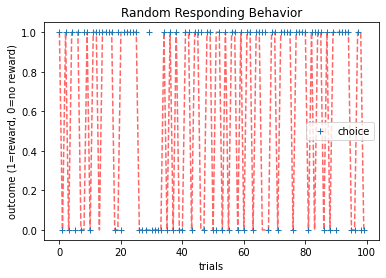

In [5]:
# plot the simulation
plt.plot(range(T), r1, 'r--', alpha=.6)
plt.plot(range(T), c1, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Random Responding Behavior')
plt.legend()
plt.show()

In [6]:
def simulate_WSLS(epsilon, T, mu):
    
    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)
    
    # last reward/action (initialize as nan)
    last_reward = np.nan
    last_choice = np.nan
    

    for t in range(T):

        # compute choice probabilities
        if np.isnan(last_reward):

            # first trial choose randomly
            p = [0.5, 0.5]

        else:

            # choice depends on last reward
            if last_reward == 1:

                # win stay (with probability 1-epsilon)
                p = [(epsilon/2) * i for i in [1, 1]]
                p[last_choice] = 1 - epsilon/2
            else:

                # lose shift (with probability 1-epsilon)
                p = [(1 - epsilon/2) * i for i in [1, 1]]
                p[last_choice] = epsilon / 2;
            
        # make choice according to choice probababilities
        c[t] = np.random.choice(range(len(mu)), p=p)

        # generate reward based on choice
        r[t] = np.random.rand() < mu[c[t]]

        last_choice = c[t]
        last_reward = r[t]
    
    return c, r

In [7]:
c2, r2 = simulate_WSLS(epsilon=.1, T=T, mu=mu)

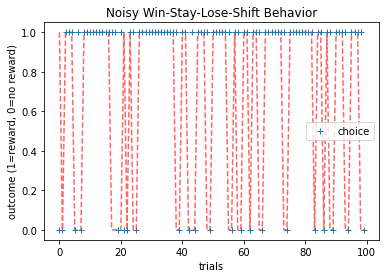

In [8]:
# plot the simulation
plt.plot(range(T), r2, 'r--', alpha=.6)
plt.plot(range(T), c2, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Noisy Win-Stay-Lose-Shift Behavior')
plt.legend()
plt.show()

In [9]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params
    
    c = np.zeros((T), dtype = int)
    r = np.zeros((T), dtype = int)

    Q_stored = np.zeros((2, T), dtype = float)
    Q = [0.5, 0.5]

    for t in range(T):

        # store values for Q_{t+1}
        Q_stored[:,t] = Q
        
        # compute choice probabilities
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # make choice according to choice probababilities
        # as weighted coin flip to make a choice
        # choose stim 0 if random number is in the [0 p0] interval
        # and 1 otherwise
        if noisy_choice:
            if np.random.random_sample(1) < p0: 
                c[t] = 0
            else:
                c[t] = 1
        else: # make choice without noise
            c[t] = np.argmax([p0,p1])
        
        # generate reward based on reward probability
        r[t] = np.random.rand() < mu[c[t]]

        # update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored

In [10]:
c3, r3, Q = simulate_RescorlaWagner([.1, 1.5], T=T, mu=mu)

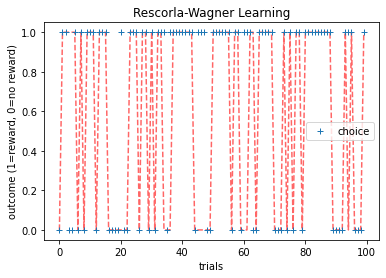

In [11]:
# plot the simulation
plt.plot(range(T), r3, 'r--', alpha=.6)
plt.plot(range(T), c3, '+', label='choice')
plt.xlabel('trials')
plt.ylabel('outcome (1=reward, 0=no reward)')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

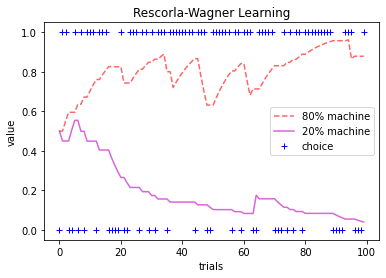

In [12]:
# plot the simulation
plt.plot(range(T), Q[1,:], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q[0,:], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c3, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

In [13]:
def plot_values(beta_hat, theta_hat, T, mu):
    c, r, Q = simulate_RescorlaWagner([beta_hat, theta_hat], T, mu)
    
    plt.plot(range(T), Q[1,:], 'r--', alpha=.6, label=f'{mu[1]*100:.0f}% machine')
    plt.plot(range(T), Q[0,:], 'm-', alpha=.6, label=f'{mu[0]*100:.0f}% machine')
    plt.plot(range(T), c, 'b+', label='choice')
    plt.xlabel('trials')
    plt.ylabel('value')
    plt.title(f'Rescorla-Wagner Learning')
    plt.legend()
    plt.show()

# interactive display
%config InlineBackend.figure_format = 'retina'

@widgets.interact(trials=widgets.IntSlider(200, min=20, max=200),
                  probability=widgets.FloatSlider(.8, min=0, max=1),
                  alpha_hat=widgets.FloatSlider(.1, min=0, max=1),
                  theta_hat=widgets.FloatSlider(1.5, min=0, max=10))

def plot_interactive(trials, probability, alpha_hat, theta_hat):
    plot_values(alpha_hat, theta_hat, int(trials), [1-probability, probability])

interactive(children=(IntSlider(value=200, description='trials', max=200, min=20), FloatSlider(value=0.8, desc…

In [14]:
def negll_RescorlaWagner(params, c, r):
    alpha, theta = params
    
    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype = float)

    for t in range(T):
        
        # compute choice probabilities for k=2
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p = [p0, 1-p0]

        # compute choice probability for actual choice
        choiceProb[t] = p[c[t]]

        # update values
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta
        
    negLL = -np.sum(np.log(choiceProb))
    
    return negLL

In [15]:
# simulate choices from RW Model
alpha = .1
theta = 1.5
c4, r4, Q2 = simulate_RescorlaWagner([alpha, theta], T=T, mu=[.2,.8])

# evaluate negative log-likelihood for 
# this simulated dataset at some other parameter values
alpha_hat = 0.2
theta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c4, r4)
print(alpha_hat,theta_hat,negLL)

0.2 1.5 66.20202127823954


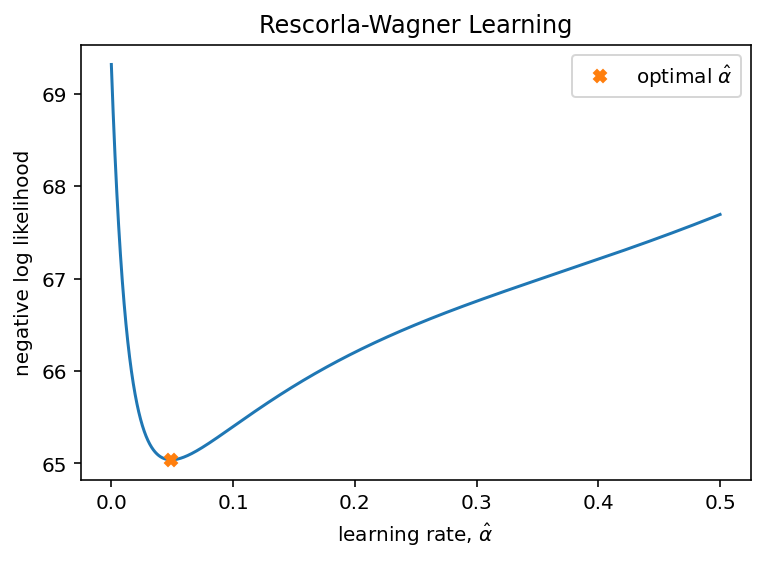

In [16]:
nLL = []
alpha_vals = np.linspace(0,0.5,1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, theta], c4, r4))

plt.plot(alpha_vals, nLL, '-')
plt.plot(alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)], 'X', label=r'optimal $\hat \alpha$')
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

In [17]:
# gradient descent to minimize neg LL
res_nll = np.inf # set initial neg LL to be inf

# guess several different starting points for alpha
for alpha_guess in np.linspace(0,1,10):
    for theta_guess in np.linspace(1,25,10):
        
        # guesses for alpha, theta will change on each loop
        init_guess = (alpha_guess, theta_guess)
        
        # minimize neg LL
        result = minimize(negll_RescorlaWagner, 
                          init_guess, 
                          (c4, r4), 
                          bounds=((0,1),(1,50)))
        
        # if current negLL is smaller than the last negLL,
        # then store current data
        if result.fun < res_nll:
            res_nll = result.fun
            param_fits = result.x

# also, compute BIC
# note: we don't need the -1 because 
# we already have the negative log likelihood!
BIC = len(init_guess) * np.log(len(c4)) + 2*res_nll

print(fr'alpha_hat = {param_fits[0]:.2f}, theta_hat = {param_fits[1]:.2f}')
print(fr'BIC = {BIC:.2f}')

alpha_hat = 0.08, theta_hat = 1.18
BIC = 139.11


In [18]:
# simulate subjects' alpha and theta params
alpha_sim = stats.truncnorm.rvs((.1),
                                (1-.25),
                                loc=.25,
                                scale=1,
                                size=(50))
theta_sim = stats.truncnorm.rvs((0-.25),
                                (10-.25),
                                loc=1.25,
                                scale=1,
                                size=(50))

# initialize lists to store params and data
negll_sim = []
Q_fit = []
alpha_fit = []
theta_fit = []

# loop over subjects
for subj in range(50):
    np.random.seed(subj)
    
    alpha = alpha_sim[subj]
    theta = theta_sim[subj]
    
    # simulate subject data based on alpha, theta
    c_sim, r_sim, Q_sim = simulate_RescorlaWagner([alpha, theta], T, mu);
    
    # gradient descent to minimize neg LL
    res_nll = np.inf
    
    # guess several different starting points for alpha
    for alpha_guess in np.linspace(0,1,10):
        
        # guesses for alpha will change
        # guesses for theta will be constant
        init_guess = (alpha_guess, 1.5)
        
        # minimize neg LL
        result = minimize(negll_RescorlaWagner, 
                          init_guess, 
                          (c_sim, r_sim), 
                          bounds=((0,1),(1,20)))
        
        # if current negLL is smaller than the last negLL,
        # then store current data
        if result.fun < res_nll:
            res_nll = result.fun
            param_fits = result.x
            Q_vals = Q_sim
    
    # append model fits to lists
    negll_sim.append(res_nll)
    Q_fit.append(Q_vals)
    alpha_fit.append(param_fits[0])
    theta_fit.append(param_fits[1])
    

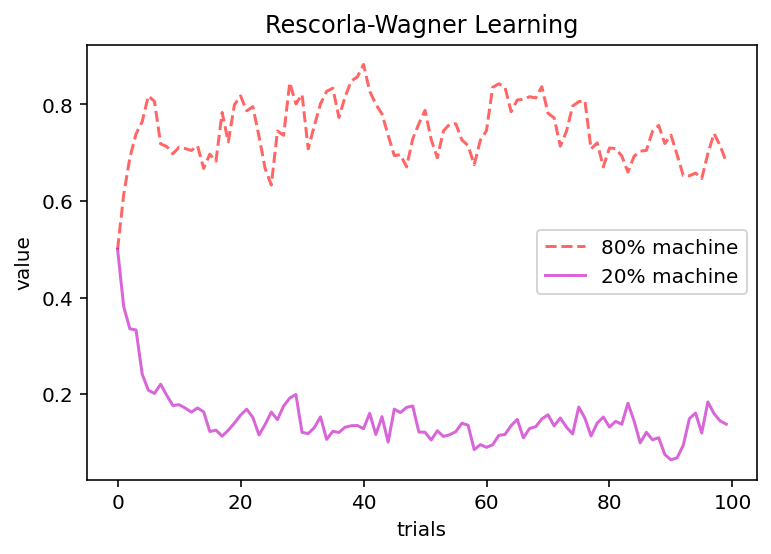

In [19]:
# plot average stimulus values over trials 
Q_means = np.mean(np.array(Q_fit), axis=0) # mean over subjects 

plt.plot(range(T), Q_means[1,:], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q_means[0,:], 'm-', alpha=.6, label='20% machine')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()

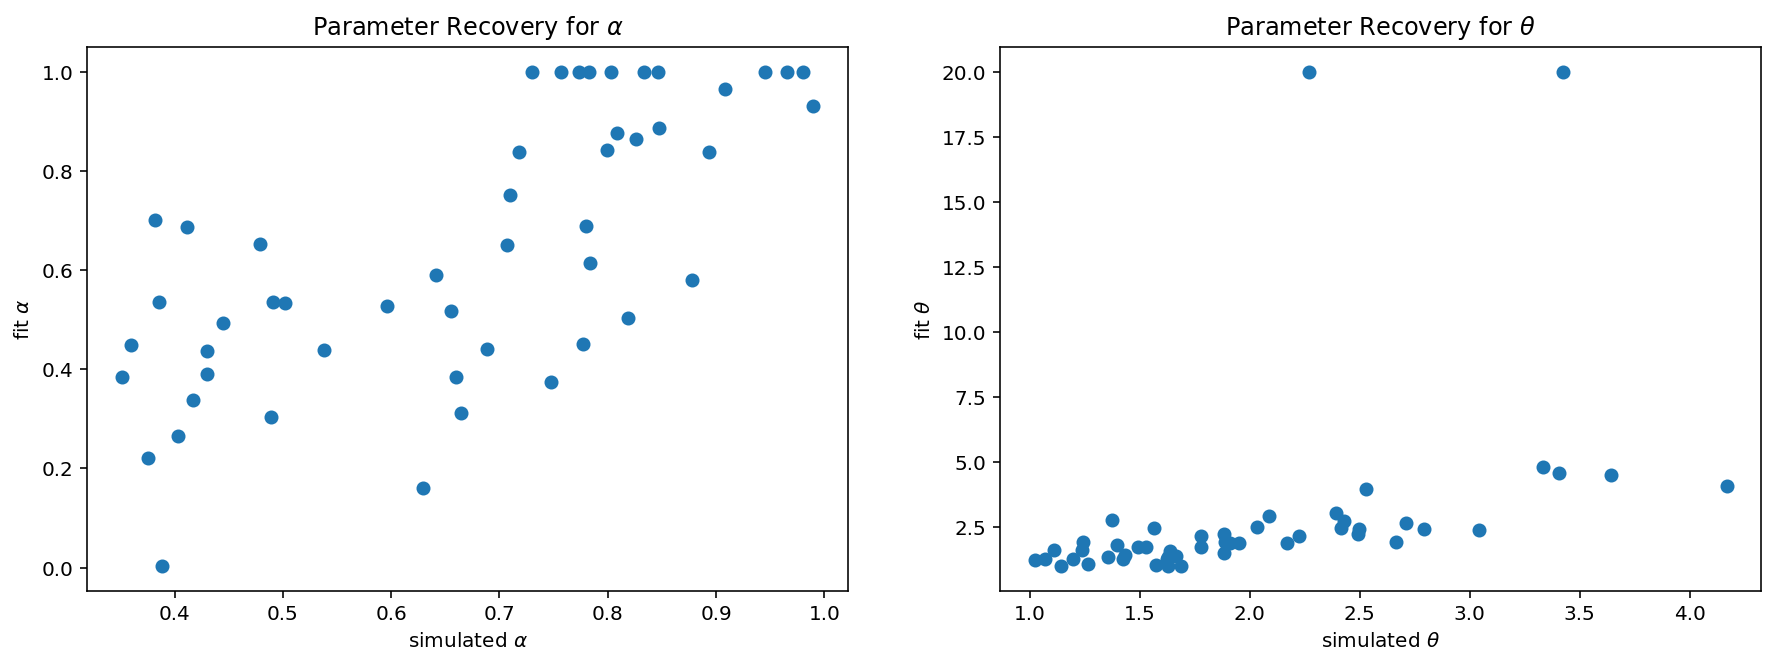

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# parameter recovery for alpha
axes[0].plot(alpha_sim, alpha_fit, 'o')
axes[0].set(ylabel=r'fit $\alpha$',
            xlabel=r'simulated $\alpha$',
            title=fr'Parameter Recovery for $\alpha$')

axes[1].plot(theta_sim, theta_fit, 'o')
axes[1].set(ylabel=r'fit $\theta$',
            xlabel=r'simulated $\theta$',
            title=fr'Parameter Recovery for $\theta$')
plt.show()